In [1]:
pip install --upgrade fosforml

Requirement already up-to-date: fosforml in /opt/conda/lib/python3.9/site-packages (1.1.8)
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade numpy

  Using cached https://files.pythonhosted.org/packages/b9/14/78635daab4b07c0930c919d451b8bf8c164774e6a3413aed04a6d95758ce/numpy-2.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
ERROR: snowflake-ml-python 1.5.0 has requirement numpy<2,>=1.23, but you'll have numpy 2.0.2 which is incompatible.
ERROR: scikit-learn 1.3.2 has requirement numpy<2.0,>=1.17.3, but you'll have numpy 2.0.2 which is incompatible.
ERROR: catboost 1.2.7 has requirement numpy<2.0,>=1.16.0, but you'll have numpy 2.0.2 which is incompatible.
  Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade seaborn

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.9/site-packages (0.13.2)
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install pandas
!pip install snowflake-ml-python
!pip install requests

You should consider upgrading via the 'pip install --upgrade pip' command.
  Using cached https://files.pythonhosted.org/packages/54/30/c2a907b9443cf42b90c17ad10c1e8fa801975f01cb9764f3f8eb8aea638b/numpy-1.26.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
  Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [5]:
pip install ydata-profiling --upgrade

Requirement already up-to-date: ydata-profiling in /opt/conda/lib/python3.9/site-packages (4.10.0)
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import fosforml
from fosforml.model_manager.snowflakesession import get_session
my_session = get_session()

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')

In [8]:
my_session.connection.database

'ASSORTMENT_PLANNING'

In [9]:
my_session.connection.schema

'CPG_BRONZE'

In [10]:
table_name = "ASSORTMENT_PLANNING.CPG_BRONZE.SALES_CLEAN"

In [11]:
sf_df = my_session.sql("select * from {}".format(table_name))

In [12]:
type(sf_df)

snowflake.snowpark.dataframe.DataFrame

In [13]:
df=sf_df.to_pandas()

In [14]:
type(df)

pandas.core.frame.DataFrame

In [15]:
df.head(5)

,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE,DISTRIBUTOR_CODE,OUTLET_CODE,CITY,STATE,COUNTY,STREET,PRODUCT_CODE,CATEGORY,SUBCATEGORY,BRAND
0,202312,2023-12-26,2023-11-27,372.73,2,0.000650,372.727273,202212,DB0110,OL112848,Carbondale,Illinois,City Center,Str2,PRD0118,Soap,Medicated Soap,Burgundy
1,202312,2023-12-26,2023-11-27,436.36,3,0.000900,436.363636,202212,DB0110,OL112848,Carbondale,Illinois,City Center,Str2,PRD0131,Soap,Toilet Soap,Grape vine
2,202312,2023-12-24,2023-11-27,202.82,2,0.000214,209.090909,202212,DB0209,OL112555,Shelbyville,Tennessee,City Center,Str5,PRD0065,Hair Care,Hair Oil,Crimson
3,202312,2023-12-29,2023-11-27,142.86,16,0.000384,142.857143,202212,DB0655,OL113173,Renton,Washington,Orange,Str2,PRD0106,Hair Care,Shampoo,Hair & Shoulders
4,202312,2023-12-17,2023-11-27,145.45,1,0.000300,145.454545,202212,DB0652,OL112373,Wallingford,Connecticut,Dolphin,Str1,PRD0070,Perfume and Deodrants,Female Deodrant,Pista green


In [16]:
df.shape

(966400, 18)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966400 entries, 0 to 966399
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   MNTH_CODE         966400 non-null  int32  
 1   TRANS_DATE        966400 non-null  object 
 2   START_DATE        966400 non-null  object 
 3   SALES_VALUE       966400 non-null  float64
 4   SALES_UNITS       966400 non-null  int16  
 5   SALES_VOLUME      966400 non-null  float64
 6   SALES_PTR_VALUE   966400 non-null  float64
 7   OC_CODE           966400 non-null  int32  
 8   DISTRIBUTOR_CODE  966400 non-null  object 
 9   OUTLET_CODE       966400 non-null  object 
 10  CITY              966400 non-null  object 
 11  STATE             966400 non-null  object 
 12  COUNTY            966400 non-null  object 
 13  STREET            966400 non-null  object 
 14  PRODUCT_CODE      966400 non-null  object 
 15  CATEGORY          966400 non-null  object 
 16  SUBCATEGORY       96

## Converting to datetime data type

In [18]:
df['TRANS_DATE'] = pd.to_datetime(df['TRANS_DATE'])
df['START_DATE'] = pd.to_datetime(df['START_DATE'])

In [19]:
df.describe()

,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE
count,966400.000000,966400,966400,966400.000000,966400.000000,966400.000000,966400.000000,966400.000000
mean,202372.876450,2024-03-01 03:47:10.976821504,2024-02-14 23:17:36.278145536,446.417454,12.696476,0.000931,457.814679,202206.573263
min,202309.000000,2023-08-29 00:00:00,2023-08-28 00:00:00,2.860000,1.000000,0.000011,1.785714,202201.000000
25%,202312.000000,2023-11-30 00:00:00,2023-11-27 00:00:00,140.000000,2.000000,0.000368,142.857143,202204.000000
50%,202403.000000,2024-03-03 00:00:00,2024-02-27 00:00:00,192.240000,6.000000,0.000448,198.181818,202207.000000
75%,202406.000000,2024-06-04 00:00:00,2024-05-29 00:00:00,450.000000,16.000000,0.000900,450.000000,202209.000000
max,202408.000000,2024-08-27 00:00:00,2024-07-31 00:00:00,145728.120000,10240.000000,0.275500,151800.000000,202212.000000
std,44.525843,NaN,NaN,1053.355633,40.761336,0.002063,1101.769102,3.404526


In [20]:
df.columns

Index(['MNTH_CODE', 'TRANS_DATE', 'START_DATE', 'SALES_VALUE', 'SALES_UNITS',
       'SALES_VOLUME', 'SALES_PTR_VALUE', 'OC_CODE', 'DISTRIBUTOR_CODE',
       'OUTLET_CODE', 'CITY', 'STATE', 'COUNTY', 'STREET', 'PRODUCT_CODE',
       'CATEGORY', 'SUBCATEGORY', 'BRAND'],
      dtype='object')

In [21]:
df.isnull().sum()

MNTH_CODE           0
TRANS_DATE          0
START_DATE          0
SALES_VALUE         0
SALES_UNITS         0
SALES_VOLUME        0
SALES_PTR_VALUE     0
OC_CODE             0
DISTRIBUTOR_CODE    0
OUTLET_CODE         0
CITY                0
STATE               0
COUNTY              0
STREET              0
PRODUCT_CODE        0
CATEGORY            0
SUBCATEGORY         0
BRAND               0
dtype: int64

In [22]:
df.duplicated().sum()

3158

In [23]:
df.corr(numeric_only=True)

,MNTH_CODE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE
MNTH_CODE,1.000000,-0.007954,-0.011117,-0.005767,-0.007843,-0.791833
SALES_VALUE,-0.007954,1.000000,0.331870,0.925910,0.996460,0.005674
SALES_UNITS,-0.011117,0.331870,1.000000,0.427627,0.334911,0.013232
SALES_VOLUME,-0.005767,0.925910,0.427627,1.000000,0.927547,0.004323
SALES_PTR_VALUE,-0.007843,0.996460,0.334911,0.927547,1.000000,0.006129
OC_CODE,-0.791833,0.005674,0.013232,0.004323,0.006129,1.000000


In [24]:
# Find unique dates
df['TRANS_DATE'].nunique()

303

In [25]:
# Create features from date column
df['YEAR'] = df['TRANS_DATE'].dt.year
df['MONTH'] = df['TRANS_DATE'].dt.month
df['DAY'] = df['TRANS_DATE'].dt.day
df['DAY_OF_WEEK'] = df['TRANS_DATE'].dt.day_of_week + 1 # Monday is 1 and sunday is 7
df['QUARTER'] = df['TRANS_DATE'].dt.quarter
df['DAY_OF_YEAR'] = df['TRANS_DATE'].dt.dayofyear

In [26]:
# Set option to display all columns
pd.set_option('display.max_columns', None)

In [27]:
df.head(5)

,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE,DISTRIBUTOR_CODE,OUTLET_CODE,CITY,STATE,COUNTY,STREET,PRODUCT_CODE,CATEGORY,SUBCATEGORY,BRAND,YEAR,MONTH,DAY,DAY_OF_WEEK,QUARTER,DAY_OF_YEAR
0,202312,2023-12-26,2023-11-27,372.73,2,0.000650,372.727273,202212,DB0110,OL112848,Carbondale,Illinois,City Center,Str2,PRD0118,Soap,Medicated Soap,Burgundy,2023,12,26,2,4,360
1,202312,2023-12-26,2023-11-27,436.36,3,0.000900,436.363636,202212,DB0110,OL112848,Carbondale,Illinois,City Center,Str2,PRD0131,Soap,Toilet Soap,Grape vine,2023,12,26,2,4,360
2,202312,2023-12-24,2023-11-27,202.82,2,0.000214,209.090909,202212,DB0209,OL112555,Shelbyville,Tennessee,City Center,Str5,PRD0065,Hair Care,Hair Oil,Crimson,2023,12,24,7,4,358
3,202312,2023-12-29,2023-11-27,142.86,16,0.000384,142.857143,202212,DB0655,OL113173,Renton,Washington,Orange,Str2,PRD0106,Hair Care,Shampoo,Hair & Shoulders,2023,12,29,5,4,363
4,202312,2023-12-17,2023-11-27,145.45,1,0.000300,145.454545,202212,DB0652,OL112373,Wallingford,Connecticut,Dolphin,Str1,PRD0070,Perfume and Deodrants,Female Deodrant,Pista green,2023,12,17,7,4,351


In [28]:
'''from ydata_profiling import ProfileReport
profile=ProfileReport(df,explorative=True)
profile.to_file("autoeda_v1.html")'''

'from ydata_profiling import ProfileReport\nprofile=ProfileReport(df,explorative=True)\nprofile.to_file("autoeda_v1.html")'

In [29]:
df_dup = df[df.duplicated()].sort_values(by=['TRANS_DATE','SALES_UNITS','OUTLET_CODE'])

In [30]:
df_unique = df.drop_duplicates()

In [31]:
df_unique.shape

(963242, 24)

In [32]:
df_check = df_unique.sort_values(by='TRANS_DATE')
df_check.head()

,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE,DISTRIBUTOR_CODE,OUTLET_CODE,CITY,STATE,COUNTY,STREET,PRODUCT_CODE,CATEGORY,SUBCATEGORY,BRAND,YEAR,MONTH,DAY,DAY_OF_WEEK,QUARTER,DAY_OF_YEAR
369528,202309,2023-08-29,2023-08-28,142.86,16,0.000384,142.857143,202209,DB0209,OL160188,Oneida,New York,Silver,Str4,PRD0147,Kids Care,Baby Cream,Mint,2023,8,29,2,3,241
60526,202309,2023-08-29,2023-08-28,8.93,1,0.000024,8.928571,202209,DB0110,OL160064,Fredericksburg,Virginia,Stephens,Str5,PRD0106,Hair Care,Shampoo,Hair & Shoulders,2023,8,29,2,3,241
37424,202309,2023-08-29,2023-08-28,125.00,14,0.000392,125.000000,202209,DB0706,OL144185,Hobart,Oklahoma,City Center,Str2,PRD0094,Perfume and Deodrants,Unisex Perfume,Mocha,2023,8,29,2,3,241
37423,202309,2023-08-29,2023-08-28,142.86,16,0.000384,142.857143,202209,DB0110,OL32611,Corvallis,Oregon,Scott,Str1,PRD0106,Hair Care,Shampoo,Hair & Shoulders,2023,8,29,2,3,241
37422,202309,2023-08-29,2023-08-28,304.23,3,0.000321,313.636364,202209,DB0655,OL144498,Towson,Maryland,City Center,Str5,PRD0064,Hair Care,Conditioner,Bamboo,2023,8,29,2,3,241


In [33]:
df_all_dates = pd.date_range(start='2023-08-29', end='2024-08-27').tolist()

In [34]:
missing_dates=set(df_all_dates) - set(df_unique['TRANS_DATE'])
len(missing_dates)

62

In [35]:
# Calculate the week number for each date
df_check['WEEK_NUMBER'] = df_check['TRANS_DATE'].dt.isocalendar().week

In [36]:
df_check.head()

,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE,DISTRIBUTOR_CODE,OUTLET_CODE,CITY,STATE,COUNTY,STREET,PRODUCT_CODE,CATEGORY,SUBCATEGORY,BRAND,YEAR,MONTH,DAY,DAY_OF_WEEK,QUARTER,DAY_OF_YEAR,WEEK_NUMBER
369528,202309,2023-08-29,2023-08-28,142.86,16,0.000384,142.857143,202209,DB0209,OL160188,Oneida,New York,Silver,Str4,PRD0147,Kids Care,Baby Cream,Mint,2023,8,29,2,3,241,35
60526,202309,2023-08-29,2023-08-28,8.93,1,0.000024,8.928571,202209,DB0110,OL160064,Fredericksburg,Virginia,Stephens,Str5,PRD0106,Hair Care,Shampoo,Hair & Shoulders,2023,8,29,2,3,241,35
37424,202309,2023-08-29,2023-08-28,125.00,14,0.000392,125.000000,202209,DB0706,OL144185,Hobart,Oklahoma,City Center,Str2,PRD0094,Perfume and Deodrants,Unisex Perfume,Mocha,2023,8,29,2,3,241,35
37423,202309,2023-08-29,2023-08-28,142.86,16,0.000384,142.857143,202209,DB0110,OL32611,Corvallis,Oregon,Scott,Str1,PRD0106,Hair Care,Shampoo,Hair & Shoulders,2023,8,29,2,3,241,35
37422,202309,2023-08-29,2023-08-28,304.23,3,0.000321,313.636364,202209,DB0655,OL144498,Towson,Maryland,City Center,Str5,PRD0064,Hair Care,Conditioner,Bamboo,2023,8,29,2,3,241,35


In [37]:
# Calculate the year difference from the first date
df_check['YEAR_DIFF'] = df_check['TRANS_DATE'].dt.year - df_check['TRANS_DATE'].dt.year.min()

# Calculate the continuous week number
df_check['CONTINUOUS_WEEK_NUMBER'] = df_check['WEEK_NUMBER'] + df_check['YEAR_DIFF'] * 52

# Adjust for the first year weeks
first_year_weeks = df_check[df_check['YEAR_DIFF'] == 0]['WEEK_NUMBER'].max()
df_check['CONTINUOUS_WEEK_NUMBER'] = df_check.apply(
    lambda row: row['CONTINUOUS_WEEK_NUMBER'] - (52 - first_year_weeks) if row['YEAR_DIFF'] > 0 else row['CONTINUOUS_WEEK_NUMBER'],
    axis=1
)
df_check['CONTINUOUS_WEEK_NUMBER']=df_check['CONTINUOUS_WEEK_NUMBER']-34

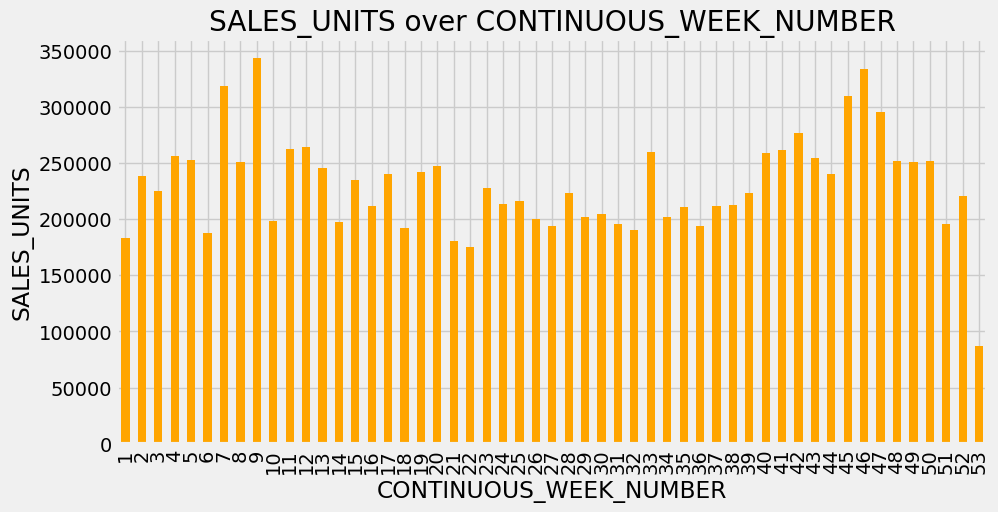

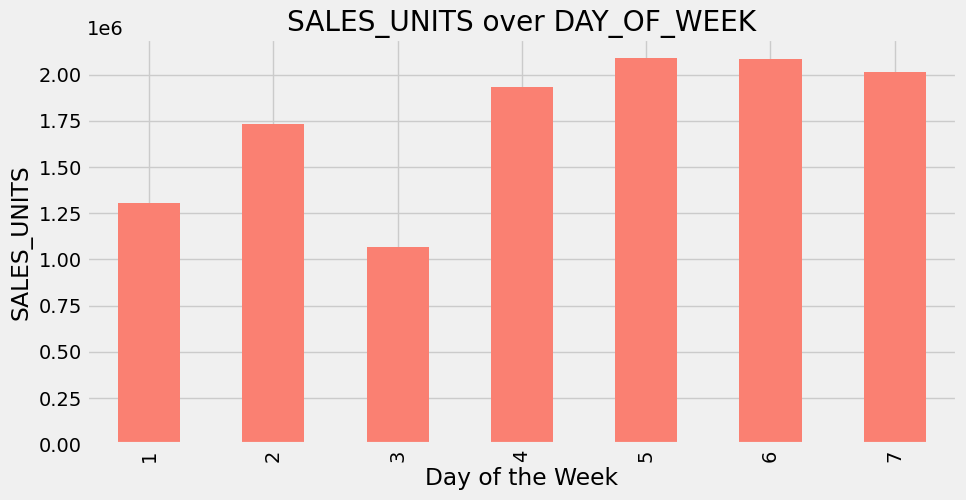

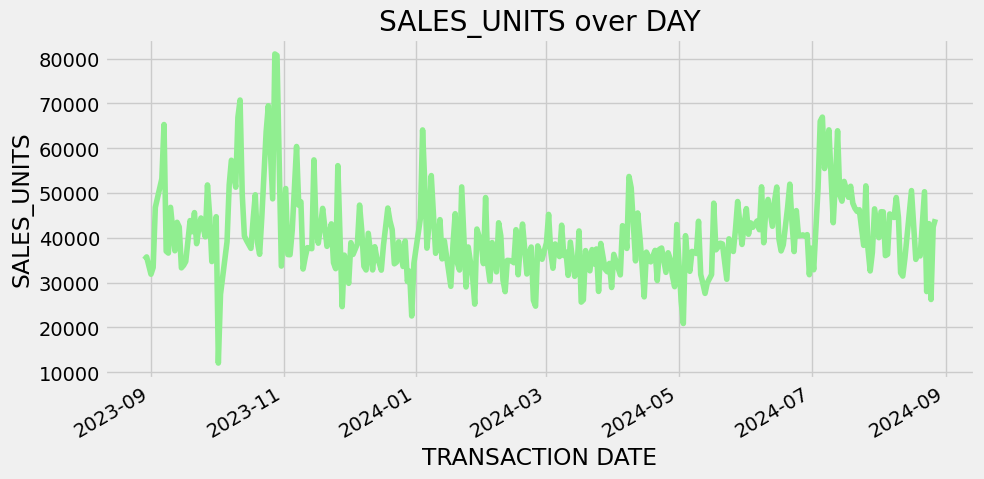

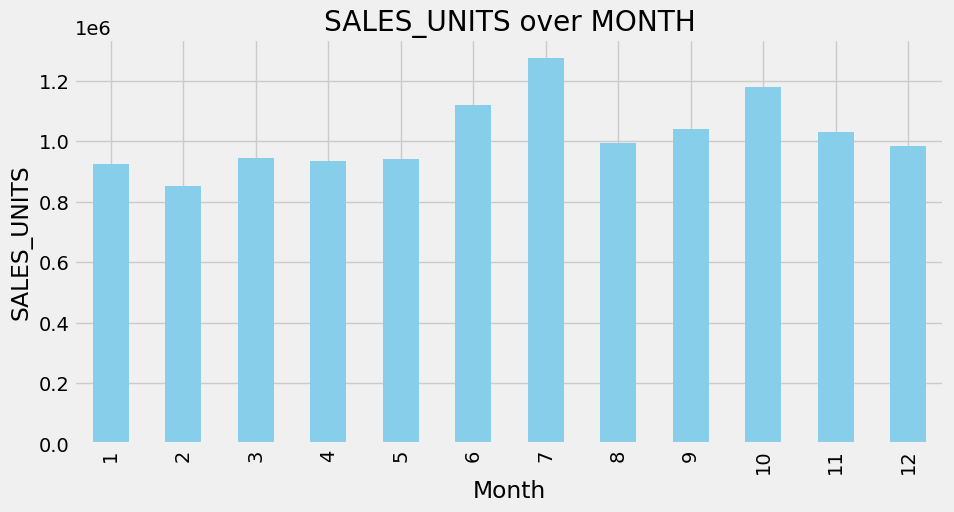

In [38]:
import matplotlib.pyplot as plt

# Plot SALES_UNITS over CONTINUOUS_WEEK_NUMBER
plt.figure(figsize=(10, 5))
df_check.groupby('CONTINUOUS_WEEK_NUMBER')['SALES_UNITS'].sum().plot(kind='bar', color='orange')
plt.title('SALES_UNITS over CONTINUOUS_WEEK_NUMBER')
plt.xlabel('CONTINUOUS_WEEK_NUMBER')
plt.ylabel('SALES_UNITS')
plt.grid(True)
plt.show()

# Plot SALES_UNITS over DAY_OF_WEEK
plt.figure(figsize=(10, 5))
df_check.groupby('DAY_OF_WEEK')['SALES_UNITS'].sum().plot(kind='bar', color='salmon')
plt.title('SALES_UNITS over DAY_OF_WEEK')
plt.xlabel('Day of the Week')
plt.ylabel('SALES_UNITS')
plt.grid(True)
plt.show()

# Plot SALES_UNITS over TRANSACTION DATE
plt.figure(figsize=(10, 5))
df_check.groupby('TRANS_DATE')['SALES_UNITS'].sum().plot(kind='line', color='lightgreen')
plt.title('SALES_UNITS over DAY')
plt.xlabel('TRANSACTION DATE')
plt.ylabel('SALES_UNITS')
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt
# Plot SALES_UNITS over MONTH
plt.figure(figsize=(10, 5))
df_check.groupby('MONTH')['SALES_UNITS'].sum().plot(kind='bar', color='skyblue')
plt.title('SALES_UNITS over MONTH')
plt.xlabel('Month')
plt.ylabel('SALES_UNITS')
plt.grid(True)
plt.show()

In [39]:
df_final = df_check.drop(['WEEK_NUMBER','YEAR_DIFF'],axis=1)

In [40]:
df_final.tail()

,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE,DISTRIBUTOR_CODE,OUTLET_CODE,CITY,STATE,COUNTY,STREET,PRODUCT_CODE,CATEGORY,SUBCATEGORY,BRAND,YEAR,MONTH,DAY,DAY_OF_WEEK,QUARTER,DAY_OF_YEAR,CONTINUOUS_WEEK_NUMBER
474606,202408,2024-08-27,2024-07-31,53.57,12,0.000132,53.571429,202208,DB0655,OL33340,Kirksville,Missouri,Santa Cruz,Str3,PRD0105,Perfume and Deodrants,Female Perfume,Garnet,2024,8,27,2,3,240,53
81893,202408,2024-08-27,2024-07-31,112.73,2,0.000220,112.727273,202208,DB0110,OL49211,Greenbelt,Maryland,Scott,Str3,PRD0015,Kids Care,Diapers,Pearl,2024,8,27,2,3,240,53
64964,202408,2024-08-27,2024-07-31,600.00,2,0.002160,600.000000,202208,DB0655,OL207603,Fremont,Nebraska,City Center,Str3,PRD0101,Soap,Soap Gels,Leo,2024,8,27,2,3,240,53
81881,202408,2024-08-27,2024-07-31,1569.75,3,0.003000,1568.181818,202208,DB0209,OL64594,Homer,Alaska,City Center,Str1,PRD0079,Perfume and Deodrants,Male Perfume,Ivory,2024,8,27,2,3,240,53
80842,202408,2024-08-27,2024-07-31,162.73,1,0.000300,162.727273,202208,DB0110,OL112453,Muskegon,Michigan,Santa Cruz,Str4,PRD0078,Lotion,Head Lotion,Saffron,2024,8,27,2,3,240,53


In [41]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 963242 entries, 369528 to 80842
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   MNTH_CODE               963242 non-null  int32         
 1   TRANS_DATE              963242 non-null  datetime64[ns]
 2   START_DATE              963242 non-null  datetime64[ns]
 3   SALES_VALUE             963242 non-null  float64       
 4   SALES_UNITS             963242 non-null  int16         
 5   SALES_VOLUME            963242 non-null  float64       
 6   SALES_PTR_VALUE         963242 non-null  float64       
 7   OC_CODE                 963242 non-null  int32         
 8   DISTRIBUTOR_CODE        963242 non-null  object        
 9   OUTLET_CODE             963242 non-null  object        
 10  CITY                    963242 non-null  object        
 11  STATE                   963242 non-null  object        
 12  COUNTY                  963242 

In [42]:
df_final['OUTLET_CODE'].nunique()

18833

In [43]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Select features
features = ['SALES_VALUE', 'CITY', 'CATEGORY', 'SALES_UNITS', 'SALES_VOLUME']
df_selected = df_final[features]

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['SALES_VALUE', 'SALES_UNITS', 'SALES_VOLUME']),
        ('cat', OneHotEncoder(), ['CITY', 'CATEGORY'])
    ])

# Apply preprocessing
df_preprocessed = preprocessor.fit_transform(df_selected)

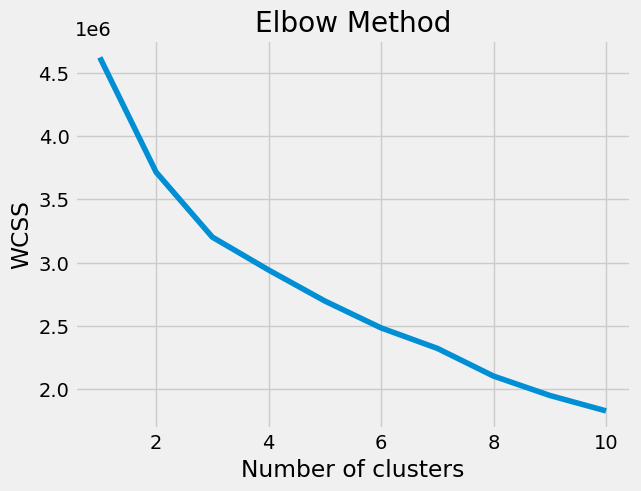

In [44]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Calculate within-cluster sum of squares for different values of n_clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_preprocessed)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [45]:
from sklearn.cluster import KMeans

# Define the model
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model
clusters = kmeans.fit_predict(df_preprocessed)

# Add cluster labels to the original DataFrame
df_final['CLUSTER'] = clusters

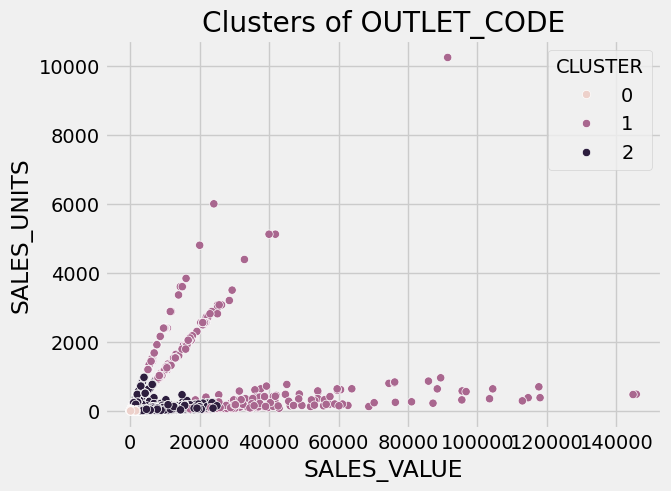

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example visualization
sns.scatterplot(x='SALES_VALUE', y='SALES_UNITS', hue='CLUSTER', data=df_final)
plt.title('Clusters of OUTLET_CODE')
plt.show()

In [47]:
df_final.head()

,MNTH_CODE,TRANS_DATE,START_DATE,SALES_VALUE,SALES_UNITS,SALES_VOLUME,SALES_PTR_VALUE,OC_CODE,DISTRIBUTOR_CODE,OUTLET_CODE,CITY,STATE,COUNTY,STREET,PRODUCT_CODE,CATEGORY,SUBCATEGORY,BRAND,YEAR,MONTH,DAY,DAY_OF_WEEK,QUARTER,DAY_OF_YEAR,CONTINUOUS_WEEK_NUMBER,CLUSTER
369528,202309,2023-08-29,2023-08-28,142.86,16,0.000384,142.857143,202209,DB0209,OL160188,Oneida,New York,Silver,Str4,PRD0147,Kids Care,Baby Cream,Mint,2023,8,29,2,3,241,1,0
60526,202309,2023-08-29,2023-08-28,8.93,1,0.000024,8.928571,202209,DB0110,OL160064,Fredericksburg,Virginia,Stephens,Str5,PRD0106,Hair Care,Shampoo,Hair & Shoulders,2023,8,29,2,3,241,1,0
37424,202309,2023-08-29,2023-08-28,125.00,14,0.000392,125.000000,202209,DB0706,OL144185,Hobart,Oklahoma,City Center,Str2,PRD0094,Perfume and Deodrants,Unisex Perfume,Mocha,2023,8,29,2,3,241,1,0
37423,202309,2023-08-29,2023-08-28,142.86,16,0.000384,142.857143,202209,DB0110,OL32611,Corvallis,Oregon,Scott,Str1,PRD0106,Hair Care,Shampoo,Hair & Shoulders,2023,8,29,2,3,241,1,0
37422,202309,2023-08-29,2023-08-28,304.23,3,0.000321,313.636364,202209,DB0655,OL144498,Towson,Maryland,City Center,Str5,PRD0064,Hair Care,Conditioner,Bamboo,2023,8,29,2,3,241,1,0


In [48]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

le_product = LabelEncoder()
df_final['PRODUCT_CODE_ENCODED'] = le_product.fit_transform(df_final['PRODUCT_CODE'])

df_final = pd.get_dummies(df_final, columns=['DISTRIBUTOR_CODE', 'CATEGORY', 'SUBCATEGORY', 'BRAND', 'CITY','STATE', 'COUNTY'])

In [49]:
df_final.head()

MNTH_CODE TRANS_DATE START_DATE  SALES_VALUE  SALES_UNITS  \
369528     202309 2023-08-29 2023-08-28       142.86           16   
60526      202309 2023-08-29 2023-08-28         8.93            1   
37424      202309 2023-08-29 2023-08-28       125.00           14   
37423      202309 2023-08-29 2023-08-28       142.86           16   
37422      202309 2023-08-29 2023-08-28       304.23            3   

        SALES_VOLUME  SALES_PTR_VALUE  OC_CODE OUTLET_CODE STREET  \
369528      0.000384       142.857143   202209    OL160188   Str4   
60526       0.000024         8.928571   202209    OL160064   Str5   
37424       0.000392       125.000000   202209    OL144185   Str2   
37423       0.000384       142.857143   202209     OL32611   Str1   
37422       0.000321       313.636364   202209    OL144498   Str5   

       PRODUCT_CODE  YEAR  MONTH  DAY  DAY_OF_WEEK  QUARTER  DAY_OF_YEAR  \
369528      PRD0147  2023      8   29            2        3          241   
60526       PRD0106  2023      8   29            2        3          241   
37424       PRD0094  2023      8   29            2        3          241   
37423       PRD0106  2023      8   29            2        3          241   
37422       PRD0064  2023      8   29            2        3          241   

        CONTINUOUS_WEEK_NUMBER  CLUSTER  PRODUCT_CODE_ENCODED  \
369528                       1        0                    80   
60526                        1        0                    60   
37424                        1        0                    52   
37423                        1        0                    60   
37422                        1        0                    33   

        DISTRIBUTOR_CODE_DB0110  DISTRIBUTOR_CODE_DB0209  \
369528                    False                     True   
60526                      True                    False   
37424                     False                    False   
37423                      True                    False   
37422                     False                    False   

        DISTRIBUTOR_CODE_DB0652  DISTRIBUTOR_CODE_DB0655  \
369528                    False                    False   
60526                     False                    False   
37424                     False                    False   
37423                     False                    False   
37422                     False                     True   

        DISTRIBUTOR_CODE_DB0706  CATEGORY_Dental  CATEGORY_Hair Care  \
369528                    False            False               False   
60526                     False            False                True   
37424                      True            False               False   
37423                     False            False                True   
37422                     False            False                True   

        CATEGORY_Kids Care  CATEGORY_Lotion  CATEGORY_Perfume and Deodrants  \
369528                True            False                           False   
60526                False            False                           False   
37424                False            False                            True   
37423                False            False                           False   
37422                False            False                           False   

        CATEGORY_Soap  CATEGORY_Wipes  SUBCATEGORY_Baby Cream  \
369528          False           False                    True   
60526           False           False                   False   
37424           False           False                   False   
37423           False           False                   False   
37422           False           False                   False   

        SUBCATEGORY_Baby Shampoo  SUBCATEGORY_Beauty Soap  \
369528                     False                    False   
60526                      False                    False   
37424                      False                    False   
37423                      False                    False   
3742

In [50]:
df_featureset = df_final.copy()